# Solving the 1D Wave Equation using Physics-Informed Neural Networks (PINN)

This project aims to solve the 1D wave equation using a Physics-Informed Neural Network (PINN). The wave equation describes the propagation of waves, such as sound, light, or water waves, and is given by:

$$
\frac{∂^2 u}{∂ t^2} = c^2 \frac{∂^2 u}{∂ x^2}
$$

where:
- The function $ u $ represents the wave itself. It is a function of position $ x $ and time $ t $. For a vibrating string, $ u $ could represent the vertical displacement of a point on the string at position $ x $ and time $ t $.
- The constant $ c $ represents the wave speed, which is set to $ 1 $ for simplicity. This could be the speed of sound in air, the speed of light in a vacuum, or the speed of a wave traveling along a string. It depends on the properties of the medium the wave is traveling through.
- $ \frac{∂^2 u}{∂ t^2} $ is the second partial derivative of $ u $ with respect to time. It represents the acceleration of the wave (how fast the displacement is changing in time).
- $ \frac{∂^2 u}{∂ x^2} $ is the second partial derivative of $ u $ with respect to space. It represents the curvature of the wave (how steep or curved the wave is in space).

The focus is on solving this equation over the domain $ x∈[0,1] $ and $ t∈[0,T] $, with initial and boundary conditions defined as follows:
- Initial displacement: $ u(x,0)=sin(πx) $.
- Initial velocity: $ \frac{∂u}{∂t}(x,0)=0 $.
- Boundary conditions: $ u(0,t)=u(1,t)=0 $.

The solution is modeled using a PINN, where the neural network is trained to satisfy the wave equation as a constraint and the given initial and boundary conditions. The PINN allows the neural network to directly learn the solution while respecting known physical laws. The model is trained not just on data points but also on the governing equations, which guides the training process and ensures the solution adheres to the wave equation.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set wave speed
c = 1.0

In [3]:
# Define the PINN model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layer1 = nn.Linear(2, 20)
        self.layer2 = nn.Linear(20, 20)
        self.layer3 = nn.Linear(20, 20)
        self.output_layer = nn.Linear(20, 1)

    def forward(self, x, t):
        input = torch.cat((x, t), dim=1)  # Combine x and t inputs
        h = torch.tanh(self.layer1(input))
        h = torch.tanh(self.layer2(h))
        h = torch.tanh(self.layer3(h))
        return self.output_layer(h)

In [4]:
# Define the loss function
def wave_pinn_loss(model, x, t):
    # Ensure gradient tracking for x and t
    x.requires_grad = True
    t.requires_grad = True

    # Predict u(x, t) with the model
    u = model(x, t)

    # Calculate first and second time derivatives
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Calculate first and second spatial derivatives
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Physics-informed loss (wave equation)
    physics_loss = torch.mean((u_tt - c**2 * u_xx) ** 2)

    # Initial condition loss at t = 0
    t_zeros = torch.zeros_like(x, requires_grad=True)  # t = 0 with requires_grad=True
    u0 = model(x, t_zeros)
    initial_loss = torch.mean((u0 - torch.sin(np.pi * x))**2)

    # Velocity loss at t = 0
    u_t0 = torch.autograd.grad(u0, t_zeros, grad_outputs=torch.ones_like(u0), create_graph=True)[0]
    velocity_loss = torch.mean(u_t0**2 + 1e-6)  # Stabilized with epsilon

    # Boundary conditions at x = 0 and x = 1
    u_left = model(torch.zeros_like(t), t)
    u_right = model(torch.ones_like(t), t)
    boundary_loss = torch.mean(u_left**2) + torch.mean(u_right**2)

    # Total loss
    total_loss = physics_loss + initial_loss + velocity_loss + boundary_loss
    return total_loss

In [5]:
# Generate training data (random points in [0, 1] x [0, T])
num_points = 1000
T = 1.0  # Time duration
x_train = torch.rand(num_points, 1, dtype=torch.float32)  # Random points in [0, 1] for x
t_train = torch.rand(num_points, 1, dtype=torch.float32) * T  # Random points in [0, T] for t

In [6]:
# Initialize the model and optimizer
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 5000

In [7]:
# Training loop with gradient clipping
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = wave_pinn_loss(model, x_train, t_train)
    
    if torch.isnan(loss):
        print(f"NaN encountered at epoch {epoch}. Stopping training.")
        break  # Stop training if NaN is encountered

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.36745089292526245
Epoch 500, Loss: 0.287708044052124
Epoch 1000, Loss: 0.19127532839775085
Epoch 1500, Loss: 0.1525924801826477
Epoch 2000, Loss: 0.1082494780421257
Epoch 2500, Loss: 0.03850014507770538
Epoch 3000, Loss: 0.011254921555519104
Epoch 3500, Loss: 0.004982796031981707
Epoch 4000, Loss: 0.002637761877849698
Epoch 4500, Loss: 0.0018045406322926283


In [8]:
# Test the trained model
x_test = torch.linspace(0, 1, 100).view(-1, 1)  # Spatial domain [0, 1]
t_test = torch.full_like(x_test, 0.5)  # Fixed time, e.g., t = 0.5
u_pred = model(x_test, t_test).detach().numpy()  # Predicted solution u(x, 0.5)

In [9]:
# Define the exact solution for comparison
def exact_solution(x, t):
    return torch.sin(np.pi * x) * torch.cos(c * np.pi * t)

# Calculate accuracy
def calculate_accuracy(model, x_test, t_test):
    u_pred = model(x_test, t_test).detach()
    u_exact = exact_solution(x_test, t_test)
    mse = torch.mean((u_pred - u_exact) ** 2)  # Mean Squared Error
    relative_error = torch.mean(torch.abs((u_pred - u_exact) / u_exact)) * 100  # Relative error in %
    return mse.item(), relative_error.item()

# Testing at a specific time, e.g., t = 0.5
x_test = torch.linspace(0, 1, 100).view(-1, 1)  # Spatial domain [0, 1]
t_test = torch.full_like(x_test, 0.5)  # Fixed time, e.g., t = 0.5
mse, relative_error = calculate_accuracy(model, x_test, t_test)

print(f"Mean Squared Error: {mse}")
print(f"Relative Error (%): {relative_error}")

Mean Squared Error: 0.00013833823322784156
Relative Error (%): inf


The infinite relative error is likely due to the true solution being zero at certain points (e.g., at the boundaries of the domain), and the model predicting a non-zero value at those points. While this indicates a problem at those specific points, the MSE shows that, overall, the model is performing reasonably well across the entire domain. 

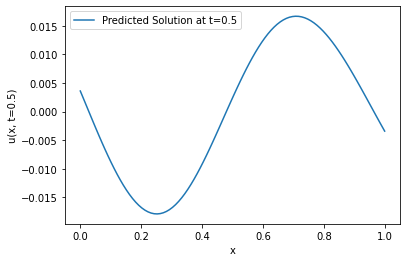

In [10]:
# Plot the results
plt.plot(x_test.numpy(), u_pred, label="Predicted Solution at t=0.5")
plt.xlabel("x")
plt.ylabel("u(x, t=0.5)")
plt.legend()
plt.show()